# Análisis Exploratorio: Adopción de Internet y Desigualdad en Sudamérica

## Objetivos del Análisis

Este notebook explora la **adopción de Internet** en países sudamericanos y su relación con la **desigualdad socioeconómica** medida por el índice de Gini. Específicamente:

1. **Evolución temporal**: Analizar las tendencias de adopción de Internet desde 2000
2. **Análisis comparativo**: Identificar patrones entre países sudamericanos
3. **Correlación con desigualdad**: Examinar la relación entre conectividad e inequidad
4. **Caso Bolivia**: Profundizar en la trayectoria boliviana comparándola con países pares

## Fuente de Datos

Los datos provienen del **Banco Mundial** a través de su API, utilizando los siguientes indicadores:
- `IT.NET.USER.ZS`: Usuarios de Internet (% de la población)
- `SI.POV.GINI`: Índice de Gini (medida de desigualdad)

## 🔧 Configuración del Entorno

Instalamos las librerías necesarias para el análisis de datos y visualización:

In [1]:
%pip install pandas seaborn requests pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 11.5 MB/s eta 0:00:00a 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/6.3 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 11.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd, requests, pycountry
import seaborn as sns, matplotlib.pyplot as plt

COUNTRIES = "ARG;BOL;BRA;CHL;COL;ECU;PRY;PER;URY;VEN"
BASE = "https://api.worldbank.org/v2/country/{countries}/indicator/{indicator}?format=json&per_page=20000"
def wb_series(indicator):
    r = requests.get(BASE.format(countries=COUNTRIES, indicator=indicator))
    r.raise_for_status()
    data = r.json()[1]
    df = pd.DataFrame(data)[["country","date","value"]]
    df["country"] = df["country"].apply(lambda x: x["value"])
    df["date"] = pd.to_numeric(df["date"], errors="coerce")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    return df.dropna(subset=["date"]).astype({"date":"int"})


### Función para obtener datos del Banco Mundial

La función `wb_series()` nos permite:
- 🌍 Obtener datos de 10 países sudamericanos (ARG, BOL, BRA, CHL, COL, ECU, PRY, PER, URY, VEN)
- 🔄 Convertir la respuesta JSON de la API en un DataFrame limpio
- 📊 Preparar los datos para análisis y visualización

**Parámetros**: `indicator` - código del indicador del Banco Mundial  
**Retorna**: DataFrame con columnas `country`, `date`, `value`

## Análisis 1: Evolución de la Adopción de Internet (2000-2023)

En esta sección analizamos las **tendencias de conectividad** en Sudamérica:

- **Crecimiento temporal**: ¿Cómo ha evolucionado el acceso a Internet desde 2000?
- **Líderes regionales**: ¿Qué países tienen mayor penetración de Internet?
- **Brechas digitales**: ¿Existen diferencias significativas entre países?

> **Indicador**: `IT.NET.USER.ZS` - Usuarios de Internet como porcentaje de la población total

📊 Muestra de datos de Internet descargados:
Total de observaciones: 235
Países incluidos: ['Argentina' 'Bolivia' 'Brazil' 'Chile' 'Colombia' 'Ecuador' 'Peru'
 'Paraguay' 'Uruguay' 'Venezuela, RB']
Rango temporal: 2000-2024

🔍 Primeros registros:
      country  date  value
1   Argentina  2023   89.2
2   Argentina  2022   88.4
3   Argentina  2021   87.2
4   Argentina  2020   85.5
5   Argentina  2019   79.9
6   Argentina  2018   77.7
7   Argentina  2017   74.3
8   Argentina  2016   71.0
9   Argentina  2015   68.0
10  Argentina  2014   64.7

📈 Últimos datos por país:
           country  date  value
196          Chile  2023   94.5
521        Uruguay  2023   89.9
1        Argentina  2023   89.2
131         Brazil  2023   84.2
391           Peru  2023   79.5
456       Paraguay  2023   78.1
261       Colombia  2023   77.3
325        Ecuador  2024   77.2
66         Bolivia  2023   70.2
592  Venezuela, RB  2017   61.6


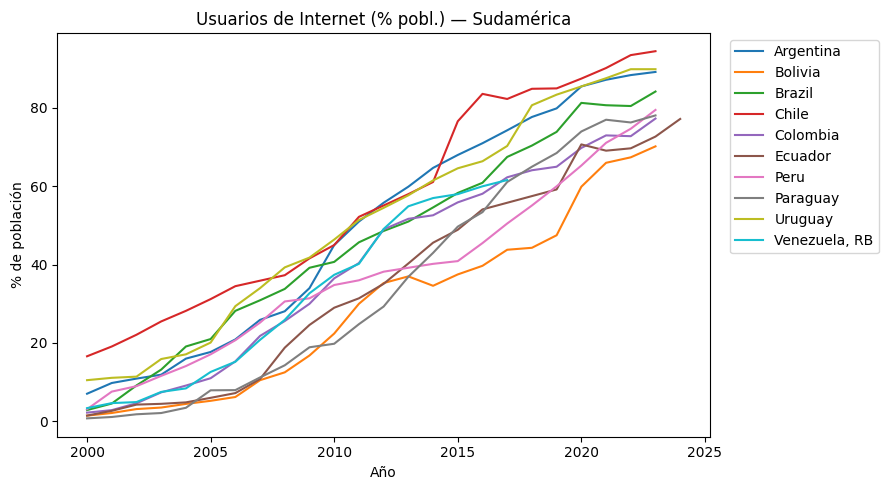

In [7]:
internet = wb_series("IT.NET.USER.ZS")  # % de población
internet = internet.query("date >= 2000").dropna(subset=["value"])

# Mostrar muestra de los datos obtenidos
print("📊 Muestra de datos de Internet descargados:")
print(f"Total de observaciones: {len(internet)}")
print(f"Países incluidos: {internet['country'].unique()}")
print(f"Rango temporal: {internet['date'].min()}-{internet['date'].max()}")
print("\n🔍 Primeros registros:")
print(internet.head(10))
print("\n📈 Últimos datos por país:")
print(internet.sort_values(['country', 'date']).groupby('country').tail(1).sort_values('value', ascending=False))

plt.figure(figsize=(9,5))
sns.lineplot(data=internet, x="date", y="value", hue="country")
plt.title("Usuarios de Internet (% pobl.) — Sudamérica")
plt.xlabel("Año"); plt.ylabel("% de población"); plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

## ⚖️ Análisis 2: Relación entre Internet y Desigualdad

¿Existe una **correlación** entre el acceso a Internet y la desigualdad socioeconómica?

### 🔍 Hipótesis a explorar:
- **H1**: Mayor conectividad podría estar asociada con menor desigualdad
- **H2**: Los países con mejor infraestructura digital podrían tener distribución más equitativa

### 📊 Metodología:
1. Obtener el **último año disponible** de cada indicador por país
2. Crear un **scatter plot** para visualizar la correlación
3. Calcular la **regresión lineal** para identificar tendencias

> **Indicadores**: Internet (`IT.NET.USER.ZS`) vs. Gini (`SI.POV.GINI`)  
> **Índice Gini**: 0 = igualdad perfecta, 100 = desigualdad máxima

📊 Muestra de datos de Gini descargados:
Total de observaciones: 650
Países con datos: ['Argentina' 'Bolivia' 'Brazil' 'Chile' 'Colombia' 'Ecuador' 'Peru'
 'Paraguay' 'Uruguay' 'Venezuela, RB']
Rango temporal disponible: 1960-2024

🔍 Últimos datos disponibles por país:
           country  date  value
1        Argentina  2023   42.4
66         Bolivia  2023   42.1
131         Brazil  2023   51.6
261       Colombia  2023   53.9
326        Ecuador  2023   44.6
456       Paraguay  2023   44.4
391           Peru  2023   40.7
521        Uruguay  2023   40.9
197          Chile  2022   43.0
603  Venezuela, RB  2006   44.7

✅ Países con datos completos para el análisis: 9
Rango años Gini: 2022-2023
Rango años Internet: 2023-2024


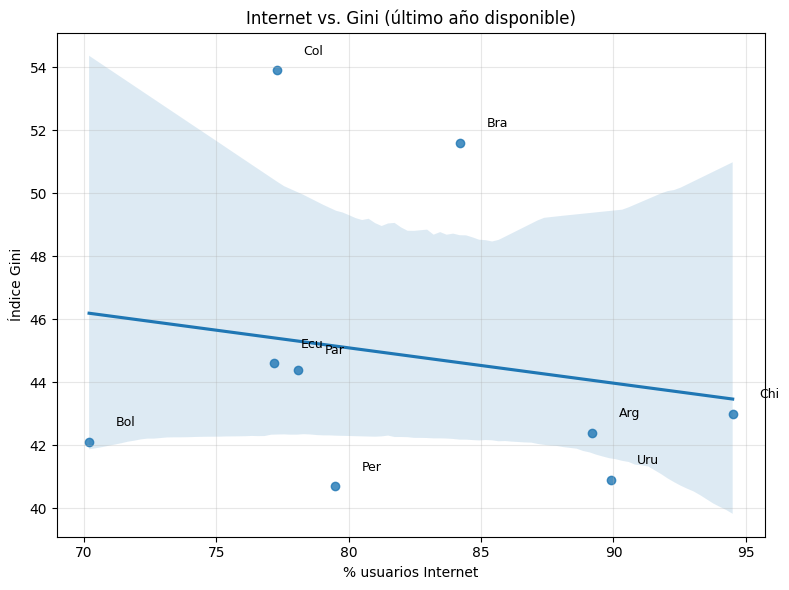


📊 Correlación Internet-Gini: -0.184


,country,internet_pct,gini,date_gini
3,Chile,94.5,43.0,2022
8,Uruguay,89.9,40.9,2023
0,Argentina,89.2,42.4,2023
2,Brazil,84.2,51.6,2023
7,Peru,79.5,40.7,2023


In [8]:
gini = wb_series("SI.POV.GINI")

# Mostrar muestra de los datos de Gini descargados
print("📊 Muestra de datos de Gini descargados:")
print(f"Total de observaciones: {len(gini)}")
print(f"Países con datos: {gini.dropna(subset=['value'])['country'].unique()}")
print(f"Rango temporal disponible: {gini['date'].min()}-{gini['date'].max()}")
print("\n🔍 Últimos datos disponibles por país:")
gini_sample = gini.dropna(subset=["value"]).sort_values(['country', 'date']).groupby('country').tail(1)
print(gini_sample[['country', 'date', 'value']].sort_values('date', ascending=False))

# Filtrar datos válidos y obtener los más recientes por país
gini_clean = gini.dropna(subset=["value"]).query("date >= 2010")
gini_ult = gini_clean.sort_values(["country","date"]).groupby("country").tail(1)

internet_ult = internet.sort_values(["country","date"]).groupby("country").tail(1)
df = pd.merge(internet_ult, gini_ult, on="country", suffixes=("_internet","_gini"))
df = df.rename(columns={"value_internet":"internet_pct","value_gini":"gini"})

print(f"\n✅ Países con datos completos para el análisis: {len(df)}")
print(f"Rango años Gini: {df['date_gini'].min()}-{df['date_gini'].max()}")
print(f"Rango años Internet: {df['date_internet'].min()}-{df['date_internet'].max()}")

plt.figure(figsize=(8,6))
sns.regplot(data=df, x="internet_pct", y="gini", ci=95)
for _, r in df.iterrows():
    plt.text(r["internet_pct"]+1, r["gini"]+0.5, r["country"][:3], fontsize=9)
plt.title("Internet vs. Gini (último año disponible)")
plt.xlabel("% usuarios Internet"); plt.ylabel("Índice Gini")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar correlación
corr = df[['internet_pct', 'gini']].corr().iloc[0,1]
print(f"\n📊 Correlación Internet-Gini: {corr:.3f}")

df.sort_values("internet_pct", ascending=False)[['country', 'internet_pct', 'gini', 'date_gini']].head()

## Análisis 3: Caso Bolivia - Trayectoria y Benchmarking Regional

### Enfoque específico en Bolivia

En esta sección profundizamos en el **caso boliviano**, comparándolo con países de contexto similar:

####  Países de comparación (peers):
- **Perú**: Geografía andina similar, contexto socioeconómico comparable
- **Paraguay**: Economía emergente, población similar  
- **Chile**: Referente regional en desarrollo digital
- **Argentina**: Mayor economía regional
- **Brasil**: Potencia regional

###  Preguntas de investigación:
1. ¿Cómo se posiciona Bolivia frente a sus pares regionales?
2. ¿Ha logrado convergencia o persisten brechas significativas?
3. ¿En qué períodos Bolivia mostró mayor/menor crecimiento relativo?

🇧🇴 Datos para el análisis de Bolivia:
Observaciones de Bolivia: 24 puntos temporales
Rango temporal Bolivia: 2000-2023
Progreso Bolivia: 1.4% (año 2000) → 70.2% (año 2023)

🌎 Datos de países pares: 120 observaciones
Países incluidos: ['Argentina' 'Brazil' 'Chile' 'Peru' 'Paraguay']

📊 Posición actual de Bolivia vs. pares (último año):
       country  date  value
196      Chile  2023   94.5
1    Argentina  2023   89.2
131     Brazil  2023   84.2
391       Peru  2023   79.5
456   Paraguay  2023   78.1
66     Bolivia  2023   70.2


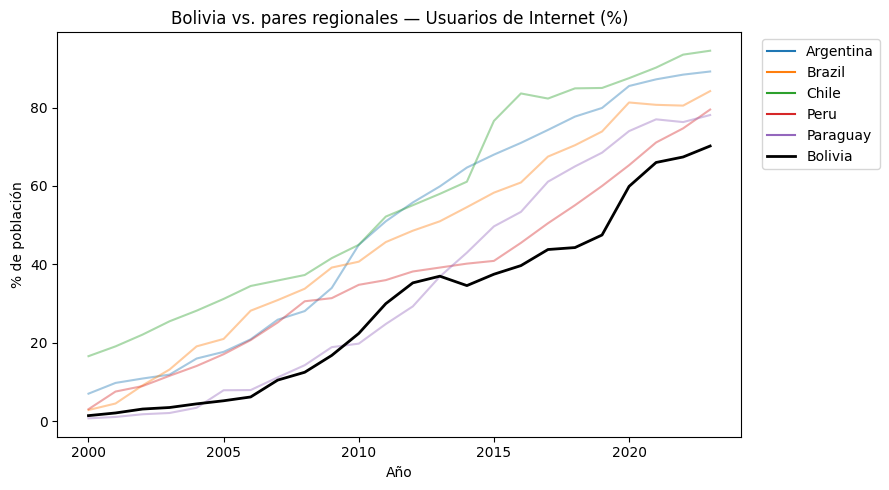

In [11]:
bol = internet.query("country == 'Bolivia'").copy()
peer = internet.query("country in ['Peru','Paraguay','Chile','Argentina','Brazil']") 

# Mostrar información sobre los datos para el análisis de Bolivia
print("🇧🇴 Datos para el análisis de Bolivia:")
print(f"Observaciones de Bolivia: {len(bol)} puntos temporales")
print(f"Rango temporal Bolivia: {bol['date'].min()}-{bol['date'].max()}")
# Ordenar por fecha para obtener correctamente primer y último año
bol_sorted = bol.sort_values('date')
print(f"Progreso Bolivia: {bol_sorted['value'].iloc[0]:.1f}% (año {bol_sorted['date'].iloc[0]}) → {bol_sorted['value'].iloc[-1]:.1f}% (año {bol_sorted['date'].iloc[-1]})")

print(f"\n🌎 Datos de países pares: {len(peer)} observaciones")
print(f"Países incluidos: {peer['country'].unique()}")
print("\n📊 Posición actual de Bolivia vs. pares (último año):")
current_comparison = internet.sort_values(['country', 'date']).groupby('country').tail(1)
bolivia_peers = current_comparison[current_comparison['country'].isin(['Bolivia', 'Peru','Paraguay','Chile','Argentina','Brazil'])]
print(bolivia_peers[['country', 'date', 'value']].sort_values('value', ascending=False))

plt.figure(figsize=(9,5))
sns.lineplot(data=peer, x="date", y="value", hue="country", alpha=0.4)
sns.lineplot(data=bol, x="date", y="value", color="black", linewidth=2, label="Bolivia")
plt.title("Bolivia vs. pares regionales — Usuarios de Internet (%)")
plt.xlabel("Año"); plt.ylabel("% de población"); plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

## Conclusiones del Análisis

### **Adopción de Internet en Sudamérica**

1. **Liderazgo regional**: Chile (~94.5%), Uruguay (~90%), Argentina (~89%) son los países con mayor penetración
2. **Crecimiento acelerado**: Todos los países muestran crecimiento exponencial post-2010
3. **Brecha digital persistente**: Diferencias de >20 puntos porcentuales entre líderes y rezagados

### **Relación Internet-Desigualdad**

- **Correlación débil negativa** (r = -0.184): Sugiere que mayor conectividad podría asociarse ligeramente con menor desigualdad
- **Datos limitados**: Solo 9 países con información completa reciente
- **Casos destacados**: 
  - Uruguay: Alta conectividad (89.9%) + baja desigualdad (Gini: 40.9)
  - Brasil: Alta conectividad (84.2%) + alta desigualdad (Gini: 51.6)

###  **Caso Bolivia**

1. **Adopción tardía pero acelerada**: Crecimiento más pronunciado después de 2010
2. **Rezago persistente**: ~70% de conectividad vs. ~90% de líderes regionales
3. **Convergencia limitada**: La brecha con países pares se mantiene estable
4. **Potencial de catch-up**: Trayectoria ascendente sostenida desde 2010

---

## **Próximos Pasos de Investigación**

1. **Análisis causal**: ¿La conectividad reduce desigualdad o vice versa?
2. **Factores explicativos**: Rol de políticas públicas, infraestructura, educación
3. **Segmentación**: Análisis por áreas urbanas/rurales, grupos etarios, niveles socioeconómicos
4. **Impacto sectorial**: Efectos en educación, salud, empleo, emprendimiento
5. **Benchmarking internacional**: Comparación con países de desarrollo similar fuera de la región

---

*Análisis realizado con datos del Banco Mundial (2024) | Última actualización: 2023-2024*